A couple more questions about the results from 01/26:

* Do they persist in higher quality thresholds?
* What's the deal with the bigger CNVs?
* Can we have some sort of stats to assess the findings?

# Varying Q

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
import glob
ped_file = '/data/sudregp/cnv/simplex.ped'
wes_prefix = ['CLIA', 'CCGO', 'WPS']

# cleaning up the data for this analysis
fid = open('/home/sudregp/data/cnv/exclude.txt', 'r')
exclude_list = [line.rstrip() for line in fid]
fid.close()
fid = open('/home/sudregp/data/cnv/exclude_multikids.txt', 'r')
exclude_list += [line.rstrip() for line in fid]
fid.close()

trios = []
affected = []
controls = []
samples = []
famids = []
fid = open(ped_file, 'r')
for line in fid:
    famid, sid, fa, mo, sex, aff = line.rstrip().split('\t')
    if (fa[:4] in wes_prefix and mo[:4] in wes_prefix and
        sid[:4] in wes_prefix and sid not in exclude_list):
        fam = {}
        fam['child'] = sid
        if aff == '1':
            affected.append(sid)
        else:
            controls.append(sid)
        fam['father'] = fa
        fam['mother'] = mo
        fam['famid'] = famid
        trios.append(fam)
        samples += [sid, fa, mo]
        famids.append(famid)
fid.close()
samples = set(samples)
famids = set(famids)
good_kids = [t['child'] for t in trios]

print 'Working with %d samples, in %d families' % (len(samples), len(famids))

Working with 88 samples, in 20 families


In [13]:
for q in [50, 60, 70, 80, 90]:
    print '\n=== Q %d ===' % q
    fname = '/home/sudregp/data/cnv/xhmm_clean/denovo_q%d_clean_lenLT250_genes.reg' % q
    fid = open(fname)
    genes = {}
    for line in fid:
        if line.find('RANGE') >= 0:
            gene = line.split(' ')[-2]
            genes[gene] = 0
        elif line.find('DUP') > 0 or line.find('DEL') > 0:
            genes[gene] += 1
    fid.close()
    df = pd.DataFrame.from_dict(genes, orient='index')
    df.columns = ['count']
    print df.sort_values(by='count', ascending=False).head(10)
    print '\n'
    dfs = df.sort_values(by='count', ascending=False).head(8)
    for index, count in dfs.iterrows():
        nlines = count[0]
        gene = index
        fid = open(fname)
        for line in fid:
            if line.find(gene) >= 0:
                print line.rstrip()
                for i in range(nlines + 1):
                    line = fid.next()
                    print line.rstrip()
        fid.close()


=== Q 50 ===
         count
ABHD13       5
LCORL        3
SP3          3
CHD9         2
NCAPG        2
DR1          2
ETNK1        2
MTFR2        2
REV3L        2
CCDC168      2


RANGE (+/- 0kb )  [ 13 108870762 108886603 ABHD13 ]
 FID           IID      PHE  CHR          BP1          BP2   TYPE       KB     OLAP   OLAP_U   OLAP_R
   1   CLIA_400122        2   13    108882417    108884732    DUP    2.315        1   0.1462   0.1462
   1   CLIA_400158        1   13    108882417    108886344    DEL    3.927        1   0.2479   0.2479
   1   CLIA_400123        2   13    108882665    108885500    DUP    2.835        1    0.179    0.179
   1   CLIA_400178        2   13    108882844    108886540    DEL    3.696        1   0.2334   0.2334
   1   CCGO_800979        1   13    108884227    108884732    DUP    0.505        1  0.03194  0.03194
RANGE (+/- 0kb )  [ 4 17844838 18023483 LCORL ]
 FID           IID      PHE  CHR          BP1          BP2   TYPE       KB     OLAP   OLAP_U   OLAP_R
   1 

OK, so going higher to 70 or lower to 50 we still have similar results. 

# Bigger CNVs

Let's take a quick look at what's up with the bigger CNVs:

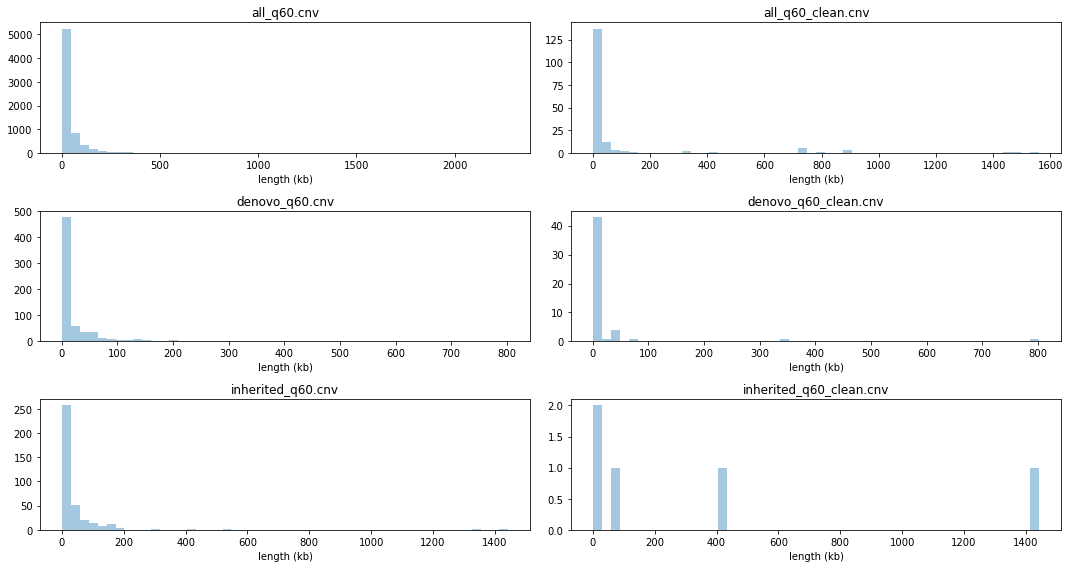

In [14]:
data_dir = '/home/sudregp/data/cnv/xhmm_clean/'
files = glob.glob(data_dir + '/*_q60*.cnv')
files.sort()
plt.figure(figsize=(15,8))
i = 1
for fname in files:
    if fname.find('DATA') < 0:
        plt.subplot(3, 2, i)
        # the clean files have a header
        if fname.find('clean') >= 0:
            df = pd.read_table(fname, header=None, skiprows=1, delimiter='\s+')
        else:
            df = pd.read_table(fname, header=None)
        sns.distplot((df[4]-df[3])/1000, kde=False, bins=50)
        plt.xlabel('length (kb)')
        plt.title(fname.split('/')[-1])
        i += 1
plt.tight_layout()

In [22]:
%%bash
cd ~/data/cnv/xhmm_clean
cat denovo_q60.cnv | awk '{ if (($5-$4)/1000 > 500) { print $_, ($5-$4)/1000 } }'

1	CLIA_400178	5	86690076	87492322	1	72	19 802.246


In [21]:
%%bash
cd ~/data/cnv/xhmm_clean
cat denovo_q60.cnv | awk '{ if (($5-$4)/1000 > 250) { print $_, ($5-$4)/1000 } }'

1	CLIA_400216	16	33326701	33630152	3	93	17 303.451
1	CLIA_400134	16	33326701	33630152	3	93	17 303.451
1	CLIA_400178	1	71529027	71871700	1	98	29 342.673
1	CLIA_400178	5	86690076	87492322	1	72	19 802.246


In [23]:
print 'CLIA_400216' in affected
print 'CLIA_400134' in affected

True
True


If we just look at denovos, 400178 has the big 800Kb CNV, and also the second biggest with 342Kb. The other two kids with large denovo CNVs are also affected. Interesting...

Let's see how far down we have to go to get the first control with denovo CNV:

In [24]:
%%bash
cd ~/data/cnv/xhmm_clean
cat denovo_q60.cnv | awk '{ if (($5-$4)/1000 > 200) { print $_, ($5-$4)/1000 } }'

1	CLIA_400216	16	33326701	33630152	3	93	17 303.451
1	CLIA_400216	17	44379939	44627953	3	95	33 248.014
1	CLIA_400134	16	33326701	33630152	3	93	17 303.451
1	CLIA_400195	17	44430104	44632532	3	94	17 202.428
1	CLIA_400152	17	44414937	44627953	3	95	19 213.016
1	CLIA_400212	16	32268881	32486853	3	89	11 217.972
1	CLIA_400178	1	71529027	71871700	1	98	29 342.673
1	CLIA_400178	4	70811826	71020253	1	92	53 208.427
1	CLIA_400178	5	86690076	87492322	1	72	19 802.246
1	CLIA_400178	5	99921895	100144777	1	91	10 222.882


In [25]:
print 'CLIA_400195' in affected
print 'CLIA_400152' in affected
print 'CLIA_400212' in affected

False
False
False


So, just to round it off, it looks like anything above 225 Kbs is ADHD. Also, other than the big one, they're all quite high quality:

In [26]:
%%bash
cd ~/data/cnv/xhmm_clean
cat denovo_q60.cnv | awk '{ if (($5-$4)/1000 > 225) { print $_, ($5-$4)/1000 } }'

1	CLIA_400216	16	33326701	33630152	3	93	17 303.451
1	CLIA_400216	17	44379939	44627953	3	95	33 248.014
1	CLIA_400134	16	33326701	33630152	3	93	17 303.451
1	CLIA_400178	1	71529027	71871700	1	98	29 342.673
1	CLIA_400178	5	86690076	87492322	1	72	19 802.246


A few more questions:

* How does it look at Q50?
* Do the other siblings have mutations around those regions? 
* Where do these mutation lie?
* What about the inherited mutations?

In [27]:
%%bash
cd ~/data/cnv/xhmm_clean
cat denovo_q60_clean.cnv | awk '{ if (($5-$4)/1000 > 225) { print $_, ($5-$4)/1000 } }'

   1   CLIA_400178    1     71529027     71871700      1           98       29  342.673
   1   CLIA_400178    5     86690076     87492322      1           72       19  802.246


Hum, apparently those mutations for the other 2 kids are common in the population (i.e. not in the clean set)? Should check more on that. But if could also be that we can go even lower in the clean set to see when the first control shows up:

In [28]:
%%bash
cd ~/data/cnv/xhmm_clean
cat denovo_q50.cnv | awk '{ if (($5-$4)/1000 > 225) { print $_, ($5-$4)/1000 } }'

1	CLIA_400216	1	143400814	143664229	3	50	8 263.415
1	CLIA_400216	16	33326701	33630152	3	93	17 303.451
1	CLIA_400216	17	44379939	44627953	3	95	33 248.014
1	CLIA_400134	16	33326701	33630152	3	93	17 303.451
1	CLIA_400203	3	86115732	86990556	1	94	17 874.824
1	CLIA_400201	1	17034432	17264317	1	58	27 229.885
1	CLIA_400201	21	9907082	10215458	1	99	8 308.376
1	CLIA_400123	15	20777564	21140921	1	92	22 363.357
1	CLIA_400144	2	88095135	88327312	3	56	11 232.177
1	CLIA_400153	14	22695008	22925802	3	92	31 230.794
1	CLIA_400138	16	32163406	32447428	3	93	34 284.022
1	CLIA_400178	1	71529027	71871700	1	98	29 342.673
1	CLIA_400178	3	86116004	86990556	1	93	15 874.552
1	CLIA_400178	5	86690076	87492322	1	72	19 802.246
1	CLIA_400205	16	33402023	33630152	1	93	13 228.129


In [29]:
print 'CLIA_400203' in affected  # probably > Q50 in a parent
print 'CLIA_400201' in affected
print 'CLIA_400123' in affected
print 'CLIA_400144' in affected
print 'CLIA_400153' in affected
print 'CLIA_400205' in affected

False
False
True
False
True
True


If we take the quality down to 50, we add a few controls at that threshold as well. Let's stay at Q60 for now.

In [33]:
%%bash
cd ~/data/cnv/xhmm_clean
cat denovo_q60_clean.cnv | awk '{ if (($5-$4)/1000 > 100) { print $_, ($5-$4)/1000 } }'

   1   CLIA_400178    1     71529027     71871700      1           98       29  342.673
   1   CLIA_400178    5     86690076     87492322      1           72       19  802.246


Well, this is interesting by itself. Assuming the results in 400178 are good, there's no rare denovo CNV > 100Kb other than those. 

In [42]:
%%bash
cd ~/data/cnv/xhmm_clean
cat denovo_q60_clean.cnv | awk '{ if (($5-$4)/1000 > 5) { print $_, ($5-$4)/1000 } }'

   1   CLIA_400123    4     17845860     17879030      3           83       31  33.17
   1   CLIA_400123   12     22837754     22843415      3           85       13  5.661
   1   CLIA_400178    1     62910396     62921225      1           98       18  10.829
   1   CLIA_400178    1     71529027     71871700      1           98       29  342.673
   1   CLIA_400178    3    180321797    180334721      1           93       24  12.924
   1   CLIA_400178    4     17845860     17879761      1           92       34  33.901
   1   CLIA_400178    4     68471897     68507036      1           62       22  35.139
   1   CLIA_400178    4    100820580    100830058      1           70       12  9.478
   1   CLIA_400178    4    113186077    113191253      1           92       10  5.176
   1   CLIA_400178    5     65317020     65349964      1           88       24  32.944
   1   CLIA_400178    5     86690076     87492322      1           72       19  802.246
   1   CLIA_400178    5     89689567     8975

Actually, even above 5Kb we only get 400178, and 400123, who is also affected. Same CNV in both too. Now, do the siblings have similar CNVs? And where do they fall?

In [45]:
f = [t['famid'] for t in trios if t['child'] == 'CLIA_400178'][0]
[t['child'] for t in trios if t['famid'] == f]

['CLIA_400178', 'CLIA_400179', 'CLIA_400180']

In [48]:
%%bash
cd ~/data/cnv/xhmm_clean
grep CLIA_400179 denovo_q60_clean.cnv
grep CLIA_400180 denovo_q60_clean.cnv

In [49]:
f = [t['famid'] for t in trios if t['child'] == 'CLIA_400123'][0]
[t['child'] for t in trios if t['famid'] == f]

['CLIA_400123', 'CLIA_400195']

In [50]:
%%bash
cd ~/data/cnv/xhmm_clean
grep CLIA_400195 denovo_q60_clean.cnv

Nope, siblings don't have them. What about the bigger set (unclean)?

In [51]:
%%bash
cd ~/data/cnv/xhmm_clean
cat denovo_q60.cnv | awk '{ if (($5-$4)/1000 > 225) { print $_, ($5-$4)/1000 } }'

1	CLIA_400216	16	33326701	33630152	3	93	17 303.451
1	CLIA_400216	17	44379939	44627953	3	95	33 248.014
1	CLIA_400134	16	33326701	33630152	3	93	17 303.451
1	CLIA_400178	1	71529027	71871700	1	98	29 342.673
1	CLIA_400178	5	86690076	87492322	1	72	19 802.246


In [52]:
%%bash
cd ~/data/cnv/xhmm_clean
grep CLIA_400179 denovo_q60.cnv
grep CLIA_400180 denovo_q60.cnv

1	CLIA_400179	1	25598972	25634379	3	99	9
1	CLIA_400179	1	144955188	145075113	3	74	10
1	CLIA_400179	2	96457903	96459631	3	70	3
1	CLIA_400179	2	96697772	96698188	1	90	3
1	CLIA_400179	6	26638915	26746732	1	92	5
1	CLIA_400179	6	90572398	90573532	1	76	10
1	CLIA_400179	11	134605131	134605973	3	63	5
1	CLIA_400179	15	84858533	84869431	3	93	8
1	CLIA_400179	X	154113278	154116223	3	99	5
1	CLIA_400180	1	25598972	25667153	1	99	10
1	CLIA_400180	2	96457903	96464066	3	96	6
1	CLIA_400180	2	96696099	96698188	1	96	5
1	CLIA_400180	4	119434648	119465626	1	92	15
1	CLIA_400180	7	142045310	142045845	1	60	3
1	CLIA_400180	10	47899916	47949383	1	92	22
1	CLIA_400180	11	134605131	134605973	1	84	5
1	CLIA_400180	14	107169999	107183605	3	70	8
1	CLIA_400180	16	16458597	16463616	1	93	18


400178 is clear.

In [54]:
f = [t['famid'] for t in trios if t['child'] == 'CLIA_400216'][0]
[t['child'] for t in trios if t['famid'] == f]

['CLIA_400216', 'CLIA_400133']

In [55]:
%%bash
cd ~/data/cnv/xhmm_clean
grep CLIA_400133 denovo_q60.cnv

1	CLIA_400133	2	98139688	98162345	3	96	9
1	CLIA_400133	3	195452831	195475977	3	93	11
1	CLIA_400133	6	29274718	29324007	1	61	10
1	CLIA_400133	6	29394894	29524030	1	91	29
1	CLIA_400133	6	30570410	30572089	1	89	11
1	CLIA_400133	6	32260905	32261538	1	85	4
1	CLIA_400133	12	9633064	9728348	3	92	40
1	CLIA_400133	13	25670625	25671618	1	92	5
1	CLIA_400133	16	28615545	28621414	3	93	7
1	CLIA_400133	16	33490834	33630152	3	93	12
1	CLIA_400133	16	33736438	33752680	3	61	7
1	CLIA_400133	19	55336421	55351162	3	68	12


The CNV in chromosome 16 do overlap with one in the control kid, but not the same CNV. The chr17 CNV is clear.

In [56]:
f = [t['famid'] for t in trios if t['child'] == 'CLIA_400134'][0]
[t['child'] for t in trios if t['famid'] == f]

['CLIA_400134', 'CLIA_400175']

In [57]:
%%bash
cd ~/data/cnv/xhmm_clean
grep CLIA_400175 denovo_q60.cnv

1	CLIA_400175	1	196743908	196797425	3	99	13
1	CLIA_400175	1	196881840	196887591	3	83	7
1	CLIA_400175	6	29274383	29275503	1	91	6
1	CLIA_400175	12	9590634	9728348	3	92	43
1	CLIA_400175	14	22749291	22788898	3	65	12
1	CLIA_400175	14	64938654	64940506	3	65	14
1	CLIA_400175	22	20385663	20456795	1	98	15


We're clear here as well.

Finally, let's look at the genes affected. Again, these are the 2 main results:

In [60]:
%%bash
cd ~/data/cnv/xhmm_clean
echo "=== ALL > 225Kb ==="
cat denovo_q60.cnv | awk '{ if (($5-$4)/1000 > 225) { print $_, ($5-$4)/1000 } }'
echo "=== CLEAN > 5Kb ==="
cat denovo_q60_clean.cnv | awk '{ if (($5-$4)/1000 > 5) { print $_, ($5-$4)/1000 } }'


=== ALL > 225Kb ===
1	CLIA_400216	16	33326701	33630152	3	93	17 303.451
1	CLIA_400216	17	44379939	44627953	3	95	33 248.014
1	CLIA_400134	16	33326701	33630152	3	93	17 303.451
1	CLIA_400178	1	71529027	71871700	1	98	29 342.673
1	CLIA_400178	5	86690076	87492322	1	72	19 802.246
=== CLEAN > 5Kb ===
   1   CLIA_400123    4     17845860     17879030      3           83       31  33.17
   1   CLIA_400123   12     22837754     22843415      3           85       13  5.661
   1   CLIA_400178    1     62910396     62921225      1           98       18  10.829
   1   CLIA_400178    1     71529027     71871700      1           98       29  342.673
   1   CLIA_400178    3    180321797    180334721      1           93       24  12.924
   1   CLIA_400178    4     17845860     17879761      1           92       34  33.901
   1   CLIA_400178    4     68471897     68507036      1           62       22  35.139
   1   CLIA_400178    4    100820580    100830058      1           70       12  9.478
   1   CLIA_4

In [64]:
%%bash
cd ~/data/cnv/xhmm_clean
grep -B 2 33326701 denovo_q60_genes.reg | grep RANGE
grep -B 2 44379939 denovo_q60_genes.reg | grep RANGE
grep -B 2 71529027 denovo_q60_genes.reg | grep RANGE
grep -B 2 86690076 denovo_q60_genes.reg | grep RANGE

RANGE (+/- 0kb )  [ 16 33463506 33563243 RNU6-76P ]
RANGE (+/- 0kb )  [ 17 44372496 44415160 LRRC37A ]
RANGE (+/- 0kb )  [ 17 44376499 44439163 ARL17A ]
RANGE (+/- 0kb )  [ 17 44376912 44439134 ARL17B ]
RANGE (+/- 0kb )  [ 17 44450178 44500463 NSFP1 ]
RANGE (+/- 0kb )  [ 17 44586046 44657088 ARL17A ]
RANGE (+/- 0kb )  [ 17 44590075 44633014 LRRC37A2 ]
RANGE (+/- 0kb )  [ 1 71512188 71532865 ZRANB2-AS1 ]
RANGE (+/- 0kb )  [ 1 71528973 71546972 ZRANB2 ]
RANGE (+/- 0kb )  [ 1 71533313 71533399 MIR186 ]
RANGE (+/- 0kb )  [ 1 71547006 71703406 ZRANB2-AS2 ]
RANGE (+/- 0kb )  [ 1 71868624 72748277 NEGR1 ]
RANGE (+/- 0kb )  [ 5 86690078 86708850 CCNH ]
RANGE (+/- 0kb )  [ 5 87485449 87564696 TMEM161B ]


In [65]:
%%bash
cd ~/data/cnv/xhmm_clean
cat denovo_q60_clean.cnv | awk '{ if (($5-$4)/1000 > 5) { print $5 } }' > junk.txt
while read bp; do
    grep -B 2 $bp denovo_q60_clean_genes.reg | grep RANGE;
done < junk.txt

RANGE (+/- 0kb )  [ 4 17812435 17846487 NCAPG ]
RANGE (+/- 0kb )  [ 4 17844838 18023483 LCORL ]
RANGE (+/- 0kb )  [ 12 22778075 22843608 ETNK1 ]
RANGE (+/- 0kb )  [ 1 62901974 62917475 USP1 ]
RANGE (+/- 0kb )  [ 1 62920396 63154039 DOCK7 ]
RANGE (+/- 0kb )  [ 1 71512188 71532865 ZRANB2-AS1 ]
RANGE (+/- 0kb )  [ 1 71528973 71546972 ZRANB2 ]
RANGE (+/- 0kb )  [ 1 71533313 71533399 MIR186 ]
RANGE (+/- 0kb )  [ 1 71547006 71703406 ZRANB2-AS2 ]
RANGE (+/- 0kb )  [ 1 71868624 72748277 NEGR1 ]
RANGE (+/- 0kb )  [ 3 180319917 180336135 TTC14 ]
RANGE (+/- 0kb )  [ 3 180331795 180397283 CCDC39 ]
RANGE (+/- 0kb )  [ 4 68424445 68472616 STAP1 ]
RANGE (+/- 0kb )  [ 4 68481478 68566889 UBA6 ]
RANGE (+/- 0kb )  [ 4 100817406 100867883 DNAJB14 ]
RANGE (+/- 0kb )  [ 4 113152894 113191211 AP1AR ]
RANGE (+/- 0kb )  [ 5 65222381 65376851 ERBB2IP ]
RANGE (+/- 0kb )  [ 5 86690078 86708850 CCNH ]
RANGE (+/- 0kb )  [ 5 87485449 87564696 TMEM161B ]
RANGE (+/- 0kb )  [ 5 89689528 89705603 CETN3 ]
RANGE (+/- 0kb

Just need to check if there's anything special about these genes... also, need to come up with some stats to quantify these findings.

# inherited CNVs

Is there anything interesting in the big inherited CNVs?

In [70]:
%%bash
cd ~/data/cnv/xhmm_clean
cat inherited_q60.cnv | awk '{ if (($5-$4)/1000 > 200) { print $_, ($5-$4)/1000 } }'

1	CLIA_400204	16	50248047	50668187	3	93	97 420.14
1	CLIA_400122	15	21136505	22490083	3	92	26 1353.58
1	CLIA_400122	3	75679821	75986851	1	83	15 307.03
1	CLIA_400129	10	46717044	46918726	1	92	10 201.682
1	CLIA_400125	5	69206134	69730865	3	92	18 524.731
1	CLIA_400180	X	6451641	7894192	1	99	35 1442.55


In [69]:
%%bash
cd ~/data/cnv/xhmm_clean
cat inherited_q60_clean.cnv | awk '{ if (($5-$4)/1000 > 200) { print $_, ($5-$4)/1000 } }'

   1   CLIA_400204   16     50248047     50668187      3           93       97  420.14
   1   CLIA_400180   23      6451641      7894192      1           99       35  1442.55


In [71]:
print 'CLIA_400204' in affected
print 'CLIA_400122' in affected
print 'CLIA_400129' in affected
print 'CLIA_400125' in affected
print 'CLIA_400180' in affected

True
True
True
True
False


So, all but the chrX CNV were inherited in the affected kid. Is it there for the controls too?

In [72]:
f = [t['famid'] for t in trios if t['child'] == 'CLIA_400204'][0]
[t['child'] for t in trios if t['famid'] == f]

['CLIA_400203', 'CLIA_400204', 'CLIA_400201']

In [73]:
%%bash
cd ~/data/cnv/xhmm_clean
grep CLIA_400203 inherited_q60.cnv
grep CLIA_400201 inherited_q60.cnv

1	CLIA_400203	6	26745874	26746732	1	92	4
1	CLIA_400203	6	170948706	170949567	1	92	4
1	CLIA_400203	10	81463327	81472753	3	92	16
1	CLIA_400203	4	144914060	144940477	1	92	9
1	CLIA_400203	6	35755557	35765119	3	66	5
1	CLIA_400203	11	117008906	117009382	1	73	4
1	CLIA_400203	14	106088190	106092325	3	92	5
1	CLIA_400203	19	40389632	40399870	1	97	15
1	CLIA_400201	5	175386907	175388447	3	86	5
1	CLIA_400201	6	26745874	26746732	1	92	4
1	CLIA_400201	8	57073660	57092099	3	92	23
1	CLIA_400201	2	96696099	96698188	3	97	5
1	CLIA_400201	5	34191199	34218519	1	92	6
1	CLIA_400201	14	106088190	106092325	3	92	5
1	CLIA_400201	19	40389632	40399870	1	97	15


All clear.

In [74]:
f = [t['famid'] for t in trios if t['child'] == 'CLIA_400122'][0]
[t['child'] for t in trios if t['famid'] == f]

['CLIA_400122', 'CLIA_400135']

In [75]:
%%bash
cd ~/data/cnv/xhmm_clean
grep CLIA_400135 inherited_q60.cnv

1	CLIA_400135	4	70146142	70156559	1	92	6
1	CLIA_400135	12	9633064	9728348	3	92	40
1	CLIA_400135	15	43873104	43891182	1	92	9
1	CLIA_400135	17	747654	916474	3	94	25
1	CLIA_400135	22	42522573	42526856	1	99	9
1	CLIA_400135	19	41349642	41356338	1	98	14
1	CLIA_400135	22	25696620	25855514	3	99	18
1	CLIA_400135	Y	23655336	23710253	3	99	6


All clear.

In [76]:
f = [t['famid'] for t in trios if t['child'] == 'CLIA_400129'][0]
[t['child'] for t in trios if t['famid'] == f]

['CLIA_400129', 'CLIA_400181']

In [77]:
%%bash
cd ~/data/cnv/xhmm_clean
grep CLIA_400181 inherited_q60.cnv

1	CLIA_400181	1	16349053	16360246	3	99	21
1	CLIA_400181	1	207737129	207741402	1	65	3
1	CLIA_400181	4	49490485	49505257	3	92	7
1	CLIA_400181	11	5877922	5878915	1	90	5
1	CLIA_400181	12	31768589	31769446	1	92	5
1	CLIA_400181	15	22448336	22490083	1	92	6
1	CLIA_400181	22	24345590	24396365	1	99	16
1	CLIA_400181	X	114238541	114391271	3	99	35


All clear.

In [78]:
f = [t['famid'] for t in trios if t['child'] == 'CLIA_400125'][0]
[t['child'] for t in trios if t['famid'] == f]

['CLIA_400125', 'CLIA_400191', 'CLIA_400189', 'CLIA_400193']

In [79]:
%%bash
cd ~/data/cnv/xhmm_clean
grep CLIA_400191 inherited_q60.cnv
grep CLIA_400189 inherited_q60.cnv
grep CLIA_400193 inherited_q60.cnv

1	CLIA_400191	17	21438500	21562363	1	94	12
1	CLIA_400191	17	61994625	61996182	1	95	6
1	CLIA_400191	15	43972956	43975666	3	69	4
1	CLIA_400189	1	25598972	25634379	1	99	9
1	CLIA_400189	1	111929290	111933873	1	99	9
1	CLIA_400189	5	70307065	70389064	1	71	15
1	CLIA_400189	16	55844304	55862882	3	93	12
1	CLIA_400189	22	24345590	24396365	3	99	16
1	CLIA_400189	8	116028	134103	3	90	4
1	CLIA_400189	10	47919862	47949383	1	83	15
1	CLIA_400189	11	18954568	18956030	3	92	4
1	CLIA_400189	13	24895608	24895868	3	87	2
1	CLIA_400189	16	32858942	32891480	1	85	12
1	CLIA_400189	16	33490834	33630152	1	93	12
1	CLIA_400193	1	111929290	111933873	1	99	9
1	CLIA_400193	12	87145	91145	3	92	10
1	CLIA_400193	17	61994625	61996182	1	95	6
1	CLIA_400193	21	14469090	14470355	3	99	8
1	CLIA_400193	22	24345590	24396365	3	99	16
1	CLIA_400193	10	47919862	47949383	1	82	15
1	CLIA_400193	10	124359576	124360037	1	84	3
1	CLIA_400193	11	85342634	85347324	3	92	6
1	CLIA_400193	15	28835250	28878926	1	92	6
1	CLIA_400193	16	72107720	7210915

All clear here as well. I can look at the genes, but what does it mean? If they inherited these genes from the parents, do the parents also have some propensity to ADHD? Or maybe it's a combination of these genes and the denovos that do something? No, couldn't be the latter, as the subjects are not the same.

If we look only at the clean set, is there anything special about affected again? (discounting the chrX CNV)

In [85]:
%%bash
cd ~/data/cnv/xhmm_clean
cat inherited_q60_clean.cnv | awk '{ if (($5-$4)/1000 > 5) { print $_, ($5-$4)/1000 } }'

   1   CLIA_400204   16     50248047     50668187      3           93       97  420.14
   1   CLIA_400204    7    142045310    142104611      1           92        9  59.301
   1   CLIA_400180   23      6451641      7894192      1           99       35  1442.55
   1   CLIA_400205    2     37473119     37478675      1           97        7  5.556


In [86]:
print 'CLIA_400204' in affected
print 'CLIA_400205' in affected

True
True


Interesting... let me check 400205 siblings:

In [87]:
f = [t['famid'] for t in trios if t['child'] == 'CLIA_400205'][0]
[t['child'] for t in trios if t['famid'] == f]

['CLIA_400205', 'CLIA_400200']

In [88]:
%%bash
cd ~/data/cnv/xhmm_clean
grep CLIA_400200 inherited_q60_clean.cnv

So, in other words, if I don't check whether the CNV is inherited or denovo, in the clean set anything > 5K is affected? It might not be true, as the classification between inherited and denovo takes into consideration the quality in the parents as well. But worth checking:

In [89]:
%%bash
cd ~/data/cnv/xhmm_clean
cat all_q60_clean.cnv | awk '{ if (($5-$4)/1000 > 5) { print $_, ($5-$4)/1000 } }'

   1   CLIA_400133   12        78813       149127      1           83       13  70.314
   1   CLIA_400133   21     10215160     11098821      1           99       30  883.661
   1   CLIA_400163    1     67452080     67470197      3           39        4  18.117
   1   CLIA_400132   21     10215160     10942032      1           99       14  726.872
   1   CLIA_400158   21     10215160     10942032      1           95       14  726.872
   1   CLIA_400203    1     91380806     91404060      1           43       15  23.254
   1   CLIA_400203    3     86115732     86990556      1           94       17  874.824
   1   CLIA_400203    7    108155341    108205421      1           38        8  50.08
   1   CLIA_400203   15     41859575     41870820      3           92       19  11.245
   1   CLIA_400204    7    142045310    142104611      1           92        9  59.301
   1   CLIA_400204   13    108881453    108886540      1           81       30  5.087
   1   CLIA_400204   16     50248047     

In [91]:
%%bash
cd ~/data/cnv/xhmm_clean
cat all_q60_clean.cnv | awk '{ if (($5-$4)/1000 > 5) { print $2 } }' | uniq > junk.txt

In [94]:
fid = open('/home/sudregp/data/cnv/xhmm_clean/junk.txt', 'r')
for line in fid:
    print line.rstrip() in affected
fid.close()

False
True
True
False
False
True
False
True
False
True
False
True
True
True
False
True
False
True


That's good to know... it's nice to trust the pseq inferences more so than the total, as we cannot really classify the unknown CNVs. 

# Are there brain genes?

In [95]:
%%bash
cd ~/data/cnv/xhmm_clean
echo "=== ALL > 225Kb ==="
cat denovo_q60.cnv | awk '{ if (($5-$4)/1000 > 225) { print $_, ($5-$4)/1000 } }'
echo "=== CLEAN > 5Kb ==="
cat denovo_q60_clean.cnv | awk '{ if (($5-$4)/1000 > 5) { print $_, ($5-$4)/1000 } }'


=== ALL > 225Kb ===
1	CLIA_400216	16	33326701	33630152	3	93	17 303.451
1	CLIA_400216	17	44379939	44627953	3	95	33 248.014
1	CLIA_400134	16	33326701	33630152	3	93	17 303.451
1	CLIA_400178	1	71529027	71871700	1	98	29 342.673
1	CLIA_400178	5	86690076	87492322	1	72	19 802.246
=== CLEAN > 5Kb ===
   1   CLIA_400123    4     17845860     17879030      3           83       31  33.17
   1   CLIA_400123   12     22837754     22843415      3           85       13  5.661
   1   CLIA_400178    1     62910396     62921225      1           98       18  10.829
   1   CLIA_400178    1     71529027     71871700      1           98       29  342.673
   1   CLIA_400178    3    180321797    180334721      1           93       24  12.924
   1   CLIA_400178    4     17845860     17879761      1           92       34  33.901
   1   CLIA_400178    4     68471897     68507036      1           62       22  35.139
   1   CLIA_400178    4    100820580    100830058      1           70       12  9.478
   1   CLIA_4

In [96]:
%%bash
cd ~/data/cnv/xhmm_clean
cat denovo_q60_clean.cnv | awk '{ if (($5-$4)/1000 > 5) { print $5 } }' > junk.txt
while read bp; do
    grep -B 2 $bp denovo_q60_clean_brainGenes.reg | grep RANGE;
done < junk.txt

In [97]:
%%bash
cd ~/data/cnv/xhmm_clean
cat denovo_q60.cnv | awk '{ if (($5-$4)/1000 > 225) { print $5 } }' > junk.txt
while read bp; do
    grep -B 2 $bp denovo_q60_brainGenes.reg | grep RANGE;
done < junk.txt

Nope, none of the denovo ones. What about inherited?

In [98]:
%%bash
cd ~/data/cnv/xhmm_clean
cat inherited_q60_clean.cnv | awk '{ if (($5-$4)/1000 > 5) { print $5 } }' > junk.txt
while read bp; do
    grep -B 2 $bp inherited_q60_clean_brainGenes.reg | grep RANGE;
done < junk.txt

In [99]:
%%bash
cd ~/data/cnv/xhmm_clean
cat inherited_q60.cnv | awk '{ if (($5-$4)/1000 > 200) { print $5 } }' > junk.txt
while read bp; do
    grep -B 2 $bp inherited_q60_brainGenes.reg | grep RANGE;
done < junk.txt

Nope, neither inherited. Oh well, no cool brain pics for this paper...

# TODO

* stats for these results
* stats for gene-based (combination) results, from 01/26
* should we take a more multivariate approach to this? CON: newish method, might scare readers. PRO: give something better than single CNV/gene solution to the problem. The main idea would be to look at the .map file in plink as sparse features, and then we could just apply some simple dimensionality reductions to see if the different samples fall into different groups or correlated spcaes with other phenotypes. We could potentially even try some ML with it, for bonus points. 